In [1]:
# !pip install --upgrade pip
!pip install watermark 

In [2]:
!python --version

Python 3.10.12


In [3]:
import watermark

%load_ext watermark
#%reload_ext watermark

# see version of system, python and libraries
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 6.1.42+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Git hash: 

watermark: 2.4.3



fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


# Import basic libraries for visualizing and data manupulation

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
!pip install split-folders # from splitting dataset into train , test, val

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import Tensorflow basic libraries

In [5]:
import tensorflow as tf
from  tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D , Dropout 
from  tensorflow.keras import Sequential , Input
from tensorflow.keras.models import Model
import tensorflowjs
import  sklearn


# import evaluation libraries

In [6]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy 
from  tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix , classification_report 


# import Transfer learning modules

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16

In [8]:
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")
    
tf.test.is_built_with_cuda()

GPU is available


True

# check if gpu is available

In [9]:
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")
    
print('cuda available' , tf.test.is_built_with_cuda())

GPU is available
cuda available True


In [10]:
# constants
IMAGE_SIZE= 224
CHANNELS=3
BATCH_SIZE=16 

# Split into Train Test and Validation Folders in ratio
* Training : 80%
* Testing : 20%

In [11]:
Crops = { 
#     'Potato' : {
#         "DATASET_DIR" : '/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Potato',
#         "WORKING_DIR" : './Potato_Dataset'
#     }
#     , 'Corn': {
#         "DATASET_DIR" : '/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn',
#         "WORKING_DIR" : './Corn_Dataset'
#     },
    'Rice': {
        "DATASET_DIR" : '/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice',
        "WORKING_DIR" : './Rice_Dataset'
    },
    'Wheat': {
        "DATASET_DIR" : '/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Wheat',
        "WORKING_DIR" : './Wheat_Dataset'
    }
}

In [12]:
import splitfolders , os

for crop in Crops.keys():
    if not (os.path.exists(Crops[crop]["WORKING_DIR"]) and os.path.isdir(Crops[crop]["WORKING_DIR"])):
        # Split the dataset into train, validation, and test sets
        splitfolders.ratio(Crops[crop]["DATASET_DIR"], output=Crops[crop]["WORKING_DIR"], seed=42, ratio=(0.8, 0.2))

Copying files: 4078 files [01:02, 65.29 files/s] 
Copying files: 2942 files [00:24, 121.65 files/s]


# Data Augmentation: 
ImageDataGenerator provides a wide range of built-in image data augmentation techniques, such as rotation, zooming, shearing, and flipping. This allows you to generate augmented images on-the-fly during training, which can help improve model generalization and performance.

* rotation_range=10,     # Randomly rotate images by up to 10 degrees
* width_shift_range=0.1, # Randomly shift images horizontally by up to 10% of width
* height_shift_range=0.1,# Randomly shift images vertically by up to 10% of height
* shear_range=0.2,       # Shear intensity
* zoom_range=0.2,        # Zoom intensity
* horizontal_flip=True,  # Randomly flip images horizontally
* fill_mode='nearest'    # Fill pixels using the nearest value if augmented


In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen =  ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,         # Randomly rotate images up to 40 degrees
            width_shift_range=0.2,     # Randomly shift images horizontally by up to 20%
            height_shift_range=0.2,    # Randomly shift images vertically by up to 20%
            shear_range=0.2,           # Randomly apply shear transformations
            zoom_range=0.2,            # Randomly zoom in on images by up to 20%
            horizontal_flip=True,      # Randomly flip images horizontally
            fill_mode='nearest' 
    )


In [14]:

for crop in Crops.keys():
    print('Crop : ' , crop)
    train_dir = Crops[crop]["WORKING_DIR"] +"/train"
    test_dir = Crops[crop]["WORKING_DIR"] +"/val"
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_SIZE , IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True  
        )
    
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_SIZE , IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',  
        shuffle=False  
        )
       
 
    Crops[crop]['train_generator']  = train_generator
    Crops[crop]['test_generator']  = test_generator    

Crop :  Rice
Found 3261 images belonging to 4 classes.
Found 817 images belonging to 4 classes.
Crop :  Wheat
Found 2352 images belonging to 3 classes.
Found 590 images belonging to 3 classes.


In [15]:
for crop in Crops.keys():
    disease_class = list(Crops[crop]["train_generator"].class_indices.keys())
    num_of_classes = len(disease_class)
    Crops[crop]["disease_class"] = disease_class
    Crops[crop]["num_of_classes"] = num_of_classes 

In [16]:
for crop in Crops.keys():
    print(crop , Crops[crop]["disease_class"])
    

Rice ['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast']
Wheat ['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']


# visualizing

Visualizing Crop Disease :  Rice
Visualizing Crop Disease :  Wheat


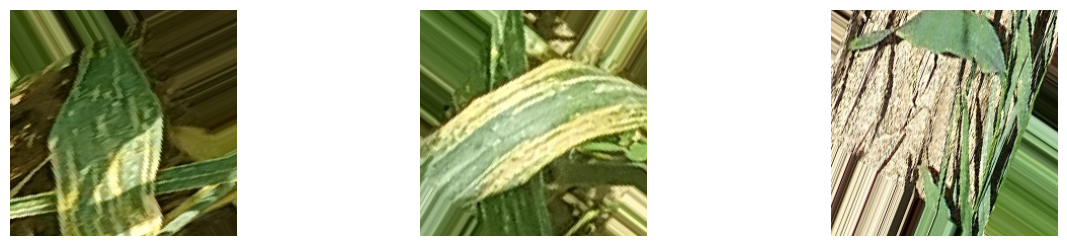

In [17]:
plt.figure( figsize= (15 , 10 ))


for crop in Crops.keys():
    print('Visualizing Crop Disease : ' , crop)
    
    num_images_to_display = 3
    for image_batch,label_batch in Crops[crop]["train_generator"] :
#         print(image_batch.shape , label_batch)

        for index in range(num_images_to_display):
            ax = plt.subplot( 3 , 3 , index + 1)
            
#             plt.title(Crops[crop]["disease_class"][ label_batch[index] ] )
            
            plt.imshow(image_batch[index])
            plt.axis('off')
        break
        
plt.show()
    

# Traing Model using VGG16_Model 

In [18]:
class VGG16_Model:
    def __init__(self  ,epoche , no_of_classes , train_generator , test_generator   ): 
        self.model = None 
        self.model_history = None
        self.train_generator = train_generator
        self.test_generator = test_generator
        self.training_sets =train_generator.samples // train_generator.batch_size
        self.testing_sets =test_generator.samples // test_generator.batch_size
        self.no_of_classes = no_of_classes
        self.EPOCHS = epoche
        
     
        
    def model_create(self):
       
        vgg = VGG16(input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS), weights = 'imagenet', include_top = False)
        
        for layer in vgg.layers:
#          print('layer '  , layer)
         layer.trainable = False
        
        
        x = Flatten()(vgg.output)
        x = Dense(128, activation = 'relu')(x) 
        x = Dense(64, activation = 'relu')(x) 
        x = Dense(self.no_of_classes, activation = 'softmax')(x) 
        
        self.model = Model(inputs = vgg.input, outputs = x)
        
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        

    def model_summuary(self):
        if self.model:
            print('Model Summary')
            print(self.model.summary())
            
    def model_fit(self):
        print('Training Start!')
             
        self.model_history = self.model.fit(
            self.train_generator,
            epochs=self.EPOCHS,
            validation_data=self.test_generator,
            steps_per_epoch=self.training_sets,
            validation_steps=self.testing_sets
            )
        print('Training Completed!')
        return self.model_history
        
    def model_evaluate(self):
        score = self.model.evaluate(self.test_generator)
        print('Accuracy Score : ' , score[1])
        print('Loss Score : ' , score[0])
    
    def  model_predict(self , test  ):
        y_pred = self.model.predict(test )
        y_pred_classes = np.argmax(y_pred, axis=1)
        return  y_pred_classes 
    
    
    def plot_accuracy_curve(self):
        plt.figure( figsize= (15 , 10 ))

        plt.subplot(2,2,1)
        plt.plot(range(self.EPOCHS) , self.model_history.history['accuracy']  , label='Training Accuracy')
        plt.plot(range(self.EPOCHS) , self.model_history.history['val_accuracy'] , label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')

        plt.subplot(2,2,2)
        plt.plot(range(self.EPOCHS) ,self.model_history.history['loss'] , label='Training Loss')
        plt.plot(range(self.EPOCHS) , self.model_history.history['val_loss'] , label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')

        plt.show()
        
    def show_classification_report(self ):
            print('showing classification report : ')
            Y_pred = self.model.predict(self.test_generator, self.testing_sets)
            y_pred = np.argmax(Y_pred, axis=1)
            y_true =self.test_generator.classes

            print(classification_report(y_true , y_pred) )
        
    def show_confusion_matrix(self):
        print('showing confusion report : ')

        Y_pred = self.model.predict(self.test_generator, self.testing_sets)
        y_pred = np.argmax(Y_pred, axis=1)
        y_true =self.test_generator.classes

        sns.heatmap(confusion_matrix(y_true , y_pred) , annot=True)
        plt.xlabel('Truth')
        plt.ylabel('Predicted')
        plt.show()
        
    def save_model(self,path):
        # Save model in h5 format so that there is just one file
        self.model.save(path)

# Create Potato Disease Model

In [19]:
modelName  = 'Potato'
vgg16_model = VGG16_Model(30 , Crops[modelName]['num_of_classes'] ,  Crops[modelName]["train_generator"] ,Crops[modelName]["test_generator"] )
vgg16_model.model_create()

KeyError: 'Potato'

In [ ]:
vgg16_model.model_fit()

In [ ]:
vgg16_model.model_summuary()
vgg16_model.model_evaluate()

In [ ]:
vgg16_model.plot_accuracy_curve()

vgg16_model.show_classification_report()

vgg16_model.show_confusion_matrix()

In [ ]:
vgg16_model.save_model('./saved_model/vgg16_potato_disease_model.h5')

# Create Corn Disease Model

In [ ]:
corn = VGG16_Model(35 , Crops['Corn']['num_of_classes'], Crops['Corn']["train_generator"] , Crops['Corn']["test_generator"] )
corn.model_create()

In [ ]:
corn.model_fit()
corn.model_summuary()
corn.model_evaluate()

In [ ]:
corn.plot_accuracy_curve()

corn.show_classification_report()

corn.show_confusion_matrix()

In [ ]:
corn.save_model('./saved_model/vgg16_corn_disease_model.h5')

# Rice Model

In [ ]:
Model_Name = 'Rice'
rice_model = VGG16_Model(45,Crops[Model_Name]['num_of_classes'], Crops[Model_Name]["train_generator"] , Crops[Model_Name]["test_generator"] )
rice_model.model_create()
rice_model.model_fit()
rice_model.model_summuary()
rice_model.model_evaluate()

58889256/58889256 [==============================] - 2s 0us/step
Training Start!
Epoch 1/45
203/203 [==============================] - 139s 641ms/step - loss: 0.8835 - accuracy: 0.5932 - val_loss: 0.8027 - val_accuracy: 0.5441
Epoch 2/45
203/203 [==============================] - 128s 633ms/step - loss: 0.7157 - accuracy: 0.6773 - val_loss: 0.7158 - val_accuracy: 0.6703
Epoch 3/45
203/203 [==============================] - 126s 624ms/step - loss: 0.6929 - accuracy: 0.6847 - val_loss: 0.6587 - val_accuracy: 0.6912
Epoch 4/45
203/203 [==============================] - 126s 622ms/step - loss: 0.6799 - accuracy: 0.6866 - val_loss: 0.5951 - val_accuracy: 0.7377
Epoch 5/45
203/203 [==============================] - 126s 620ms/step - loss: 0.6606 - accuracy: 0.7097 - val_loss: 0.7313 - val_accuracy: 0.6348
Epoch 6/45
203/203 [==============================] - 132s 653ms/step - loss: 0.6455 - accuracy: 0.7085 - val_loss: 0.6075 - val_accuracy: 0.7341
Epoch 7/45
203/203 [=======================

In [ ]:
rice_model.plot_accuracy_curve()

rice_model.show_classification_report()

rice_model.show_confusion_matrix()

In [ ]:
rice_model.save_model('./saved_model/vgg16_rice_disease_model.h5')

# Wheat Model

In [ ]:
Model_Name = 'Wheat'
model = VGG16_Model(15,Crops[Model_Name]['num_of_classes'], Crops[Model_Name]["train_generator"] , Crops[Model_Name]["test_generator"] )
model.model_create()
model.model_fit()
model.model_summuary()
model.model_evaluate()

In [ ]:
model.plot_accuracy_curve()

model.show_classification_report()

model.show_confusion_matrix()

In [ ]:
model.save_model('./saved_model/vgg16_wheat_disease_model.h5')

# Save Crop disease mapping

In [ ]:
import json

data = {  }

for crop in Crops.keys():
    print('--- Saved ' , crop , ' Model---' )
    data[crop + '_disease'] =  Crops[crop]['disease_class']
    
with open('./crop_disease_mapping.json', 'w') as json_file:
    json.dump( data, json_file)

# Testing model


In [ ]:
from tensorflow.keras.models import  load_model 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image


In [ ]:
# Load the saved model
model = load_model('/kaggle/working/saved_model/vgg16_corn_disease_model.h5')

In [ ]:
with open("/kaggle/working/crop_disease_mapping.json", 'r') as json_file:
    disease_class_mapping = json.load(json_file)
print(disease_class_mapping)

In [ ]:

# img_path = "/kaggle/working/Potato_Dataset/val/Potato___Late_Blight/86323439-ca8d-4819-ae81-800e50f85770___RS_LB 2826.JPG"
# img_path = "/kaggle/working/Potato_Dataset/val/Potato___Early_Blight/a3fe02f0-6d49-4e9a-ba9a-ac26e8b65ca9___RS_Early.B 7560.JPG"
img_path = "/kaggle/working/Corn_Dataset/val/Corn___Gray_Leaf_Spot/image (481).jpg"
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_preprocess = preprocess_input(x)

# this will exclude the initial layers from training phase as there are already been trained.


In [ ]:
# Make predictions
predicted_class_index = np.argmax(model.predict(img_preprocess) , axis=1)[0]
print(predicted_class_index)
predicted_class = disease_class_mapping['Corn_disease'][predicted_class_index]

print(f"Predicted Class: {predicted_class}")

# Saving python version and modules

In [ ]:
print('Python version  : 3.10.12')
print("tensorflowjs - " , tensorflowjs.__version__)
print("tensorflow - " , tf.__version__)
print("numpy - " , np.__version__)
print("pandas - " , pd.__version__)
print('seaborn - ' , sns.__version__)
print('split-folders' , splitfolders.__version__)
print('sklearn' , sklearn.__version__)